In [1]:
import tensorflow as tf
from utils import NUM_CLASS, IMG_SHAPE, set_seed, data_preprocess,\
                  overlay_y_in_X, randomize_y
from ffobjects import FFModel, FFLayer, ff_dense_block, ff_conv2d_block

#### Data loading and preparation

Forward-forward layers can be trained "supervised-wise" or "unsupervised-wise", depending on whether the labels are embedded/overlayed in the images or not.

In [2]:
ds_train, ds_valid = map(tf.data.Dataset.from_tensor_slices, 
                         tf.keras.datasets.mnist.load_data())

ds_train_pos = ds_train.map(data_preprocess).filter(lambda X, y: y <  5)
ds_train_neg = ds_train.map(data_preprocess).filter(lambda X, y: y >= 5)
ds_valid_pos = ds_valid.map(data_preprocess).filter(lambda X, y: y <  5)
ds_valid_neg = ds_valid.map(data_preprocess).filter(lambda X, y: y >= 5)

batch_size = 128

# "unsupervised" data, because labels are not embedded in the images.
u_datasets = (
    ds_train_pos.batch(batch_size, drop_remainder=True).cache(),
    ds_train_neg.batch(batch_size, drop_remainder=True).cache(),
    ds_valid_pos.batch(batch_size, drop_remainder=True).cache(),
    ds_valid_neg.batch(batch_size, drop_remainder=True).cache(),
)

# "supervised" data, because labels are embedded in the training images.
# Embedding of labels in validation images are handled by `FFModel.ff_evaluate`
s_datasets = (
    ds_train_pos\
        .map(overlay_y_in_X).batch(batch_size, drop_remainder=True).cache(),
    ds_train_neg\
        .map(randomize_y)\
        .map(overlay_y_in_X).batch(batch_size, drop_remainder=True).cache(),
    ds_valid_pos.batch(batch_size, drop_remainder=True).cache(),
    ds_train_neg.batch(batch_size, drop_remainder=True).cache(),
)

#### Dense models

Three models each consists of Dense layers are trained:
- A `tf.keras.Model` that uses backprop as a baseline
- A `FFModel` that expects for "unsupervised" data
- A `FFModel` that expects for "supervised" data

In [3]:
def build_dense_model(seed=100, return_ff_model=True, ff_is_unsupervised=True):
    
    set_seed(seed)
    
    b0i = FFLayer(tf.keras.layers.InputLayer, input_shape=IMG_SHAPE, name='input')
    b0o = FFLayer(tf.keras.layers.Flatten, name='input_flatten')(b0i)

    b1a, b1o = ff_dense_block(100, 'relu', 0.0001, 0.1, 1, b0o)
    b2a, b2o = ff_dense_block(100, 'relu', 0.0001, 0.1, 2, b1o)
    b3a, b3o = ff_dense_block(100, 'relu', 0.0001, 0.1, 3, b2o)
    b4a, b4o = ff_dense_block(100, 'relu', 0.0001, 0.1, 4, b3o)

    softmax_opt = tf.keras.optimizers.Adam(0.0001)
    softmax_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    softmax_metric = tf.keras.metrics.SparseCategoricalAccuracy()
    goodness_metric = tf.keras.metrics.SparseCategoricalAccuracy()
    
    b5a = FFLayer(tf.keras.layers.Concatenate, 
                  name='concat_activities')([b2a, b3a, b4a])
    b5o = FFLayer(tf.keras.layers.Lambda,
                  function=lambda X: tf.reduce_sum(X**2, axis=-1),
                  metric=goodness_metric, is_goodness_softmax=True,
                  name='goodness')(b5a)
    
    b6a = FFLayer(tf.keras.layers.Concatenate, 
                  name='concat_preNormed')([b2o, b3o, b4o])
    b6o = FFLayer(tf.keras.layers.Dense, 
                  units=NUM_CLASS, activation='linear', 
                  do_ff=False, optimizer=softmax_opt, 
                  loss_fn=softmax_loss, metric=softmax_metric,
                  name='softmax_output')(b6a)
    
    if return_ff_model:
        model = FFModel(inputs=b0i, outputs=[b1a, b2a, b3a, b4a, b5o, b6o], 
                        is_unsupervised=ff_is_unsupervised, name='Dense_FF')
        
    else:
        model = tf.keras.Model(inputs=b0i, outputs=b6o, name='Dense_BP')
        model.compile(optimizer=softmax_opt, loss=softmax_loss, metrics=softmax_metric)
    
    return model

In [4]:
%%time

u_dense_bp = build_dense_model(seed=200, return_ff_model=False)
u_dense_ff = build_dense_model(seed=200, return_ff_model=True, ff_is_unsupervised=True)
s_dense_ff = build_dense_model(seed=200, return_ff_model=True, ff_is_unsupervised=False)

print('training Dense model with backprop')
u_dense_bp_hist = u_dense_bp.fit(u_datasets[0], validation_data=u_datasets[2], epochs=20, verbose=2)

print('\n\ntraining Dense model with unsupervised-wise forward-forward algorithm')
u_dense_ff_hist = u_dense_ff.ff_train(*u_datasets, epochs=200, eval_every=5, report=['pos_pass/softmax_output', 'pos_pass/goodness'])

print('\n\ntraining Dense model with supervised-wise forward-forward algorithm')
s_dense_ff_hist = s_dense_ff.ff_train(*s_datasets, epochs=200, eval_every=5, report=['pos_pass/softmax_output', 'pos_pass/goodness'])

training Dense model with backprop
Epoch 1/20
240/240 - 12s - loss: 1.0622 - sparse_categorical_accuracy: 0.8547 - ff_binary_crossentropy: 0.0000e+00 - val_loss: 0.6653 - val_sparse_categorical_accuracy: 0.9619 - val_ff_binary_crossentropy: 0.0000e+00 - 12s/epoch - 49ms/step
Epoch 2/20
240/240 - 2s - loss: 0.5164 - sparse_categorical_accuracy: 0.9617 - ff_binary_crossentropy: 0.0000e+00 - val_loss: 0.3875 - val_sparse_categorical_accuracy: 0.9732 - val_ff_binary_crossentropy: 0.0000e+00 - 2s/epoch - 7ms/step
Epoch 3/20
240/240 - 2s - loss: 0.3325 - sparse_categorical_accuracy: 0.9715 - ff_binary_crossentropy: 0.0000e+00 - val_loss: 0.2651 - val_sparse_categorical_accuracy: 0.9787 - val_ff_binary_crossentropy: 0.0000e+00 - 2s/epoch - 7ms/step
Epoch 4/20
240/240 - 2s - loss: 0.2391 - sparse_categorical_accuracy: 0.9769 - ff_binary_crossentropy: 0.0000e+00 - val_loss: 0.1974 - val_sparse_categorical_accuracy: 0.9807 - val_ff_binary_crossentropy: 0.0000e+00 - 2s/epoch - 7ms/step
Epoch 5/20

#### Conv2D models

Three models each consists of Conv2D layers are trained:
- A `tf.keras.Model` that uses backprop as a baseline
- A `FFModel` that expects for "unsupervised" data
- A `FFModel` that expects for "supervised" data

In [5]:
def build_conv2d_model(seed=100, return_ff_model=True, ff_is_unsupervised=True):
    
    set_seed(seed)

    b0i = FFLayer(tf.keras.layers.InputLayer, input_shape=IMG_SHAPE, name='input')
    b0o = FFLayer(tf.keras.layers.Lambda, function=lambda X: tf.expand_dims(X, -1), name='input_expand_dims')(b0i)

    b1a, b1fa, b1fp, b1o = ff_conv2d_block(100, (28, 28), 'relu', None, 0.0001, 0.1, 1, b0o)
    b2a, b2fa, b2fp, b2o = ff_conv2d_block(100, ( 1,  1), 'relu', None, 0.0001, 0.1, 2, b1o)
    b3a, b3fa, b3fp, b3o = ff_conv2d_block(100, ( 1,  1), 'relu', None, 0.0001, 0.1, 3, b2o)
    b4a, b4fa, b4fp, b4o = ff_conv2d_block(100, ( 1,  1), 'relu', None, 0.0001, 0.1, 4, b3o)

    softmax_opt = tf.keras.optimizers.Adam(0.0001)
    softmax_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    softmax_metric = tf.keras.metrics.SparseCategoricalAccuracy()
    goodness_metric = tf.keras.metrics.SparseCategoricalAccuracy()
    
    b5a = FFLayer(tf.keras.layers.Concatenate, 
                  name='concat_activities')([b2fa, b3fa, b4fa])
    b5o = FFLayer(tf.keras.layers.Lambda,
                  function=lambda X: tf.reduce_sum(X**2, axis=-1),
                  metric=goodness_metric, is_goodness_softmax=True,
                  name='goodness')(b5a)
    
    b6a = FFLayer(tf.keras.layers.Concatenate, 
                  name='concat_preNormed')([b2fp, b3fp, b4fp])
    b6o = FFLayer(tf.keras.layers.Dense, 
                  units=NUM_CLASS, activation='linear', 
                  do_ff=False, optimizer=softmax_opt, 
                  loss_fn=softmax_loss, metric=softmax_metric,
                  name='softmax_output')(b6a)
    
    if return_ff_model:
        model = FFModel(inputs=b0i, outputs=[b1a, b2a, b3a, b4a, b5o, b6o], 
                        is_unsupervised=ff_is_unsupervised, name='Conv2D_FF')
        
    else:
        model = tf.keras.Model(inputs=b0i, outputs=b6o, name='Conv2D_BP')
        model.compile(optimizer=softmax_opt, loss=softmax_loss, metrics=softmax_metric)
    
    return model

In [6]:
%%time

u_conv2d_bp = build_conv2d_model(seed=200, return_ff_model=False)
u_conv2d_ff = build_conv2d_model(seed=200, return_ff_model=True, ff_is_unsupervised=True)
s_conv2d_ff = build_conv2d_model(seed=200, return_ff_model=True, ff_is_unsupervised=False)

print('training Conv2D model with backprop')
u_conv2d_bp_hist = u_conv2d_bp.fit(u_datasets[0], validation_data=u_datasets[2], epochs=20, verbose=2)

print('\n\ntraining Conv2D model with unsupervised-wise forward-forward algorithm')
u_conv2d_ff_hist = u_conv2d_ff.ff_train(*u_datasets, epochs=200, eval_every=5, report=['pos_pass/softmax_output', 'pos_pass/goodness'])

print('\n\ntraining Conv2D model with supervised-wise forward-forward algorithm')
s_conv2d_ff_hist = s_conv2d_ff.ff_train(*s_datasets, epochs=200, eval_every=5, report=['pos_pass/softmax_output', 'pos_pass/goodness'])

training Conv2D model with backprop
Epoch 1/20
240/240 - 5s - loss: 0.8554 - sparse_categorical_accuracy: 0.9414 - ff_binary_crossentropy: 0.0000e+00 - val_loss: 0.5494 - val_sparse_categorical_accuracy: 0.9766 - val_ff_binary_crossentropy: 0.0000e+00 - 5s/epoch - 22ms/step
Epoch 2/20
240/240 - 4s - loss: 0.4466 - sparse_categorical_accuracy: 0.9737 - ff_binary_crossentropy: 0.0000e+00 - val_loss: 0.3492 - val_sparse_categorical_accuracy: 0.9812 - val_ff_binary_crossentropy: 0.0000e+00 - 4s/epoch - 17ms/step
Epoch 3/20
240/240 - 3s - loss: 0.2992 - sparse_categorical_accuracy: 0.9806 - ff_binary_crossentropy: 0.0000e+00 - val_loss: 0.2466 - val_sparse_categorical_accuracy: 0.9844 - val_ff_binary_crossentropy: 0.0000e+00 - 3s/epoch - 13ms/step
Epoch 4/20
240/240 - 4s - loss: 0.2143 - sparse_categorical_accuracy: 0.9858 - ff_binary_crossentropy: 0.0000e+00 - val_loss: 0.1853 - val_sparse_categorical_accuracy: 0.9854 - val_ff_binary_crossentropy: 0.0000e+00 - 4s/epoch - 15ms/step
Epoch 5/

#### Summary

<table>
    <thead>
        <tr>
            <th></th>
            <th>algorithm</th>
            <th>epochs</th>
            <th>best accuracy by trained softmax</th>
            <th>best accuracy by goodness softmax</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td rowspan=3>Dense Model</td>
            <td>BP</td>
            <td>20</td>
            <td>99.2</td>
            <td>--</td>
        </tr>
        <tr>
            <td>FF (unsupervised-wise)</td>
            <td rowspan=2>200</td>
            <td>96.2</td>
            <td>22.7</td>
        </tr>
        <tr>
            <td>FF (supervised-wise)</td>
            <td>96.3</td>
            <td>81.1</td>
        </tr>
        <tr>
            <td rowspan=3>Conv2D Model</td>
            <td>BP</td>
            <td>20</td>
            <td>99.2</td>
            <td>--</td>
        </tr>
        <tr>
            <td>FF (unsupervised-wise)</td>
            <td rowspan=2>200</td>
            <td>95.1</td>
            <td>41.5</td>
        </tr>
        <tr>
            <td>FF (supervised-wise)</td>
            <td>94.2</td>
            <td>69.7</td>
        </tr>
    </tbody>
</table>

- It's consistent with the paper that BP (Backprop) does better than FF (Forward-forward) even in less epochs.
- It's reasonable that the "accuracy by goodness softmax" is very poor with "unsupervised" data, however, it's interesting that it can reach 41.5% as well
- "Accuracy by goodness softmax" is pretty sensitive to initialization
- No hyperparameters tuned for best performing models. They are just for demo.
- Known major difference between this and the paper's implementation is that my layers are smaller and my training sets are smaller.

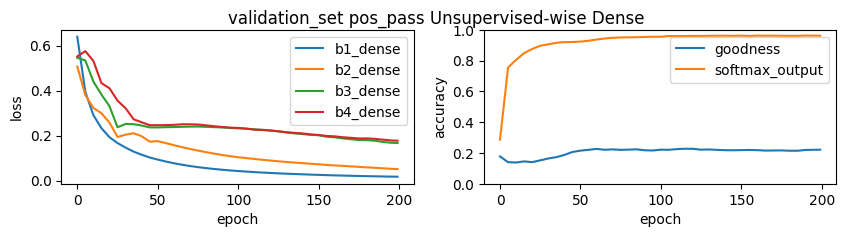

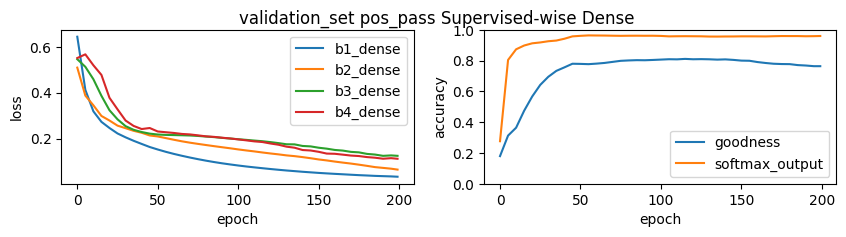

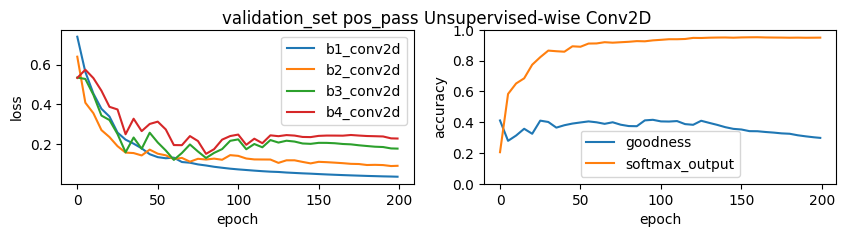

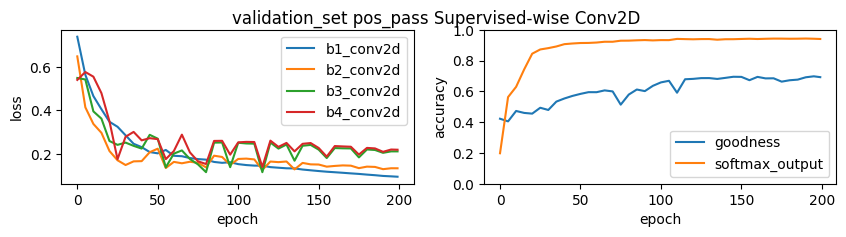

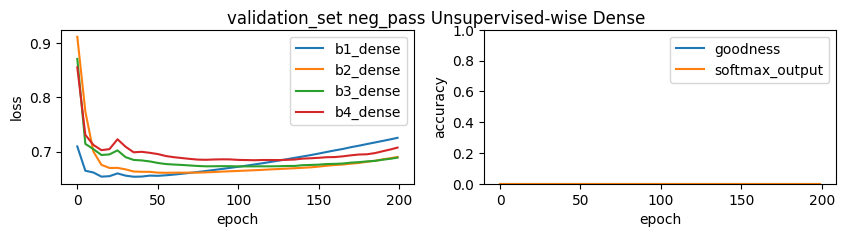

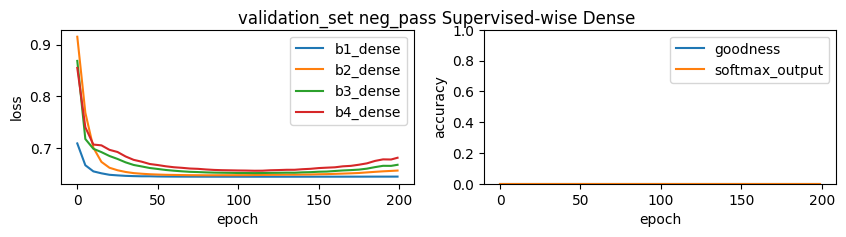

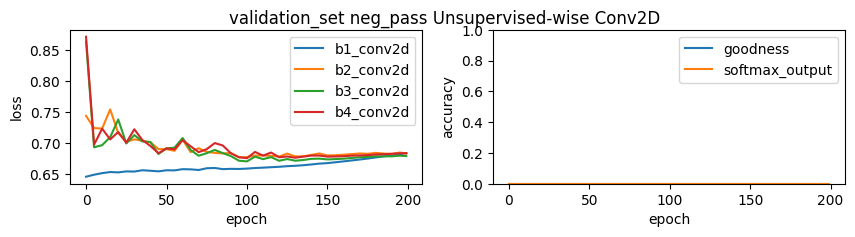

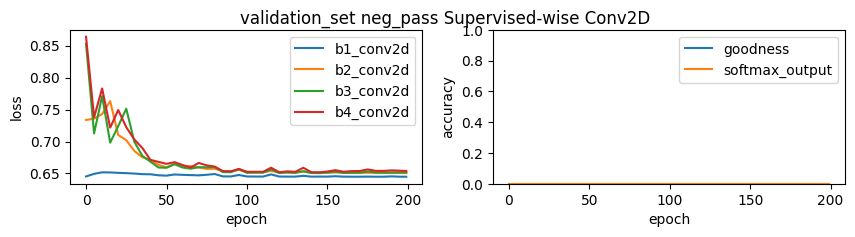

In [7]:
import pandas as pd
from matplotlib import pyplot as plt

for _pass in ['pos_pass', 'neg_pass']:
    for name, hist in [('Unsupervised-wise Dense', u_dense_ff_hist),
                       ('Supervised-wise Dense', s_dense_ff_hist),
                       ('Unsupervised-wise Conv2D', u_conv2d_ff_hist),
                       ('Supervised-wise Conv2D', s_conv2d_ff_hist),
                      ]:
        df = pd.DataFrame(
            [x['valid'][_pass] for x in hist],
            index = [x['epoch'] for x in hist]
        )

        plot1 = set(['b1_dense', 'b2_dense', 'b3_dense', 'b4_dense',
                     'b1_conv2d', 'b2_conv2d', 'b3_conv2d', 'b4_conv2d'])

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,2))
        df[sorted(set(df.columns.tolist()) & plot1)].plot(
            xlabel='epoch', ylabel='loss', ax=ax1)
        df[['goodness', 'softmax_output']].plot(
            xlabel='epoch', ylabel='accuracy', ylim=(0,1), ax=ax2)
        fig.suptitle(f'validation_set {_pass} {name}')
        plt.show()

In [8]:
u_dense_ff.summary()

Model: "Dense_FF"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 28, 28)]     0           []                               
                                                                                                  
 input_flatten (Flatten)        (None, 784)          0           ['input[0][0]']                  
                                                                                                  
 b1_dense (Dense)               (None, 100)          78500       ['input_flatten[0][0]']          
                                                                                                  
 b1_prenorm (Lambda)            (None, 100)          0           ['b1_dense[0][0]']               
                                                                                           